### Predicting Diabetes in Female Patients

A comparison of the performances of ML classifiers

In [1]:
#Libraries for all and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE

#Libraries for Naive Bayes
from sklearn.naive_bayes import GaussianNB

#Libraries for KNN
from sklearn.neighbors import KNeighborsClassifier

#Libraries for Logistic Regression
from sklearn.linear_model import LogisticRegression

#Libraries for performance measures
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
#Load data
df = pd.read_csv('diabetes.csv')
#Keep an original copy to manipulate later if needed
df_original = df.copy()
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
#Get 0 counts for each column
for col_name, col_data in df.iteritems():
    count = (df[col_name] == 0).sum()
    print("Column: ", col_name)
    print("Zeros Count: ", count, "| Percentage: ", round((count/len(col_data))*100,2), "%")

Column:  Pregnancies
Zeros Count:  111 | Percentage:  14.45 %
Column:  Glucose
Zeros Count:  5 | Percentage:  0.65 %
Column:  BloodPressure
Zeros Count:  35 | Percentage:  4.56 %
Column:  SkinThickness
Zeros Count:  227 | Percentage:  29.56 %
Column:  Insulin
Zeros Count:  374 | Percentage:  48.7 %
Column:  BMI
Zeros Count:  11 | Percentage:  1.43 %
Column:  DiabetesPedigreeFunction
Zeros Count:  0 | Percentage:  0.0 %
Column:  Age
Zeros Count:  0 | Percentage:  0.0 %
Column:  Outcome
Zeros Count:  500 | Percentage:  65.1 %


### Handling missing values

There are several methods to handling missing values. We could drop rows that contain a 0, fill it in with the mean of the feature, or conduct missing data imputation using regression (if correlation exists between features).

##### Method 1: Drop rows with 0's and replace with the mean. 

In [6]:
df_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
##Drop rows with a 0 in missing_columns list AND 0 as outcome:
missing_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for index, row in df_original.iterrows():
    if 0 in row[1:6].values and row['Outcome'] == 0:
        df_original.drop(index, inplace = True)
print(df_original['Outcome'].value_counts())

1    268
0    262
Name: Outcome, dtype: int64


In [8]:
##check columns with a 0 value
for col_name, col_data in df_original.iteritems():
    count = (df_original[col_name] == 0).sum()
    print("Column: ", col_name)
    print("Zeros Count: ", count, "| Percentage: ", round((count/len(col_data))*100,2), "%")

Column:  Pregnancies
Zeros Count:  75 | Percentage:  14.15 %
Column:  Glucose
Zeros Count:  2 | Percentage:  0.38 %
Column:  BloodPressure
Zeros Count:  16 | Percentage:  3.02 %
Column:  SkinThickness
Zeros Count:  88 | Percentage:  16.6 %
Column:  Insulin
Zeros Count:  138 | Percentage:  26.04 %
Column:  BMI
Zeros Count:  2 | Percentage:  0.38 %
Column:  DiabetesPedigreeFunction
Zeros Count:  0 | Percentage:  0.0 %
Column:  Age
Zeros Count:  0 | Percentage:  0.0 %
Column:  Outcome
Zeros Count:  262 | Percentage:  49.43 %


In [9]:
#Replace 0's with the mean of the column. 

for col in missing_columns:
    df_original[col] = df_original[col].replace(0, np.NaN)
    mean = int(df_original[col].mean(skipna = True))
    df_original[col] = df_original[col].replace(np.NaN, mean)

for col_name, col_data in df_original.iteritems():
    count = (df_original[col_name] == 0).sum()
    print("Column: ", col_name)
    print("Zeros Count: ", count, "| Percentage: ", round((count/len(col_data))*100,2), "%")

Column:  Pregnancies
Zeros Count:  75 | Percentage:  14.15 %
Column:  Glucose
Zeros Count:  0 | Percentage:  0.0 %
Column:  BloodPressure
Zeros Count:  0 | Percentage:  0.0 %
Column:  SkinThickness
Zeros Count:  0 | Percentage:  0.0 %
Column:  Insulin
Zeros Count:  0 | Percentage:  0.0 %
Column:  BMI
Zeros Count:  0 | Percentage:  0.0 %
Column:  DiabetesPedigreeFunction
Zeros Count:  0 | Percentage:  0.0 %
Column:  Age
Zeros Count:  0 | Percentage:  0.0 %
Column:  Outcome
Zeros Count:  262 | Percentage:  49.43 %


In [10]:
df_original_dropcols = df_original.copy()
df_original_dropcols.drop(['Pregnancies','SkinThickness','DiabetesPedigreeFunction','Insulin', 'BloodPressure'], axis = 1, inplace = True)


##### Method 2: Deterministic Regression Imputation

Fill in missing values with the predicted outcome of a regression model. 

In [11]:
#Create list of columns that cannot contain 0. 
#Replace 0's with NaN
missing_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in missing_columns:
    df[col] = df[col].replace(0, np.NaN)
    
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


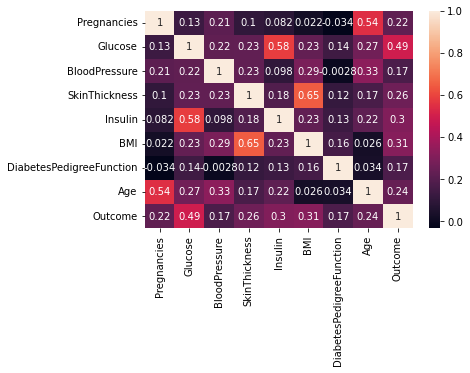

In [12]:
#Create correlation matrix
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

The only columns that can realistically have a 0 as a value are Pregnancies and Outcome. Using the correlation matrix, we observe that BMI and Skin Thickness are highly correlated and Glucose and Insulin are highly correlated. 

We'll use this information to perform missing value imputation using regression.

In [13]:
#Create test data from original df. Contains all rows from original df with any NaN.

null_data = df[df.isna().any(1)]
null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0


In [14]:
null_data.shape

(376, 9)

In [15]:
null_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [16]:
#Drop rows where Glucose and BMI are null as they will be features used in linear regression and cannot use null values. 
#BMI has 11 rows with a null value, Glucose has 5. Expecting only 11 rows to be dropped (goal is to keep as much data integrity as possible)
null_data = null_data.dropna(subset=['Glucose', 'BMI'])
null_data.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                28
SkinThickness               218
Insulin                     360
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [17]:
#Drop test data from original df to use as train data
df.dropna(axis = 0, inplace = True)

#Verify
df.shape

(392, 9)

To fill in null values, we will use linear regression using correlated features as the train and the null values as our y predict. 

1. Insulin and Glucose are highly correlated. 
2. Skin Thickness and BMI are highly correlated. 
3. Blood Pressure has no clear correlation with another feature. Might consider dropping rows where BloodPressure is null or entire column altogether. 

In [18]:
#Predicting Insulin null values using Glucose.
insulin_train_y = np.array([df['Insulin']]).reshape(-1,1) #y_train
insulin_train_x = np.array([df['Glucose']]).reshape(-1,1) #x_train

lr = LinearRegression()
lr.fit(insulin_train_x, insulin_train_y)

insulin_test_x = np.array([null_data['Glucose']]).reshape(-1,1) #x_test
insulin_pred = lr.predict(insulin_test_x) #y_pred

#set y_pred as Insulin column
null_data.loc[null_data.Insulin.isnull(), 'Insulin'] = insulin_pred
null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,212.845499,33.6,0.627,50,1
1,1,85.0,66.0,29.0,71.837009,26.6,0.351,31,0
2,8,183.0,64.0,NaN,291.183549,23.3,0.672,32,1
5,5,116.0,74.0,NaN,141.222139,25.6,0.201,30,0
7,10,115.0,NaN,NaN,138.983909,35.3,0.134,29,0


In [19]:
###Predicting Skin Thickness using BMI as train feature
null_data.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                28
SkinThickness               218
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [20]:
#Create another dataframe from null_data where Skin Thickness is null
st_null = null_data[null_data['SkinThickness'].isnull()]
st_null.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183.0,64.0,NaN,291.183549,23.3,0.672,32,1
5,5,116.0,74.0,NaN,141.222139,25.6,0.201,30,0
7,10,115.0,NaN,NaN,138.983909,35.3,0.134,29,0
10,4,110.0,92.0,NaN,127.792759,37.6,0.191,30,0
11,10,168.0,74.0,NaN,257.610099,38.0,0.537,34,1


In [21]:
#Drop st_null from null_data
null_data = null_data.dropna(subset=['SkinThickness'])
null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,212.845499,33.6,0.627,50,1
1,1,85.0,66.0,29.0,71.837009,26.6,0.351,31,0
23,9,119.0,80.0,35.0,147.936829,29.0,0.263,29,1
30,5,109.0,75.0,26.0,125.554529,36.0,0.546,60,0
34,10,122.0,78.0,31.0,154.651519,27.6,0.512,45,0


In [22]:
###Predicting Insulin null values using Glucose.
st_train_y = np.array([null_data['SkinThickness']]).reshape(-1,1) #y_train
st_train_x = np.array([null_data['BMI']]).reshape(-1,1) #x_train

lr = LinearRegression()
lr.fit(st_train_x, st_train_y)

st_test_x = np.array([st_null['BMI']]).reshape(-1,1) #x_test
st_pred = lr.predict(st_test_x) #y_pred

#set y_pred as new Skin Thickness column
st_null.loc[st_null.SkinThickness.isnull(), 'SkinThickness'] = st_pred
st_null.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183.0,64.0,20.344253,291.183549,23.3,0.672,32,1
5,5,116.0,74.0,22.601603,141.222139,25.6,0.201,30,0
7,10,115.0,NaN,32.121732,138.983909,35.3,0.134,29,0
10,4,110.0,92.0,34.379082,127.792759,37.6,0.191,30,0
11,10,168.0,74.0,34.771664,257.610099,38.0,0.537,34,1


In [23]:
#Concatenate all three dataframes
frames = [df, null_data, st_null]
df = pd.concat(frames)

#df should now include all of the predicted values
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


In [24]:
df.isnull().sum()

Pregnancies                  0
Glucose                      0
BloodPressure               28
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

In [25]:
#Final dataframe for model prediction:
df = df.dropna(subset=['BloodPressure'])

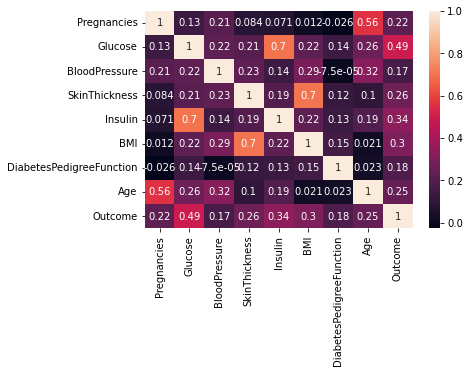

In [26]:
#Create correlation matrix
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

[0.09999276 0.22318253 0.08957445 0.09794797 0.1237827  0.12550591
 0.11172946 0.12828421]


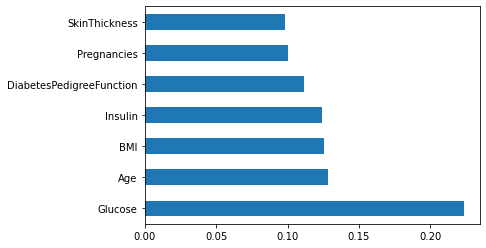

In [27]:
#Use ExtraTreesClassifier to determine which columns have the most impact on the outcome
from sklearn.ensemble import ExtraTreesClassifier

X = df.iloc[:,0:-1]  
y = df.iloc[:,-1]    

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_)

#plot results
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

Based on the correlation matrix and the extra trees classifier, we can conclude that the top 3 features are Glucose, BMI, and Age. Insulin is highly correlated with Glucose and can be dropped to prevent overfitting. 

This will be done in two separate dataframes.

In [28]:
#Create separate dataframe to test with feature selection conducted. 
df_dropcols = df.copy()
df_dropcols.drop(['Pregnancies','SkinThickness','DiabetesPedigreeFunction','Insulin', 'BloodPressure'], axis = 1, inplace = True)
df_dropcols.head()

,Glucose,BMI,Age,Outcome
3,89.0,28.1,21,0
4,137.0,43.1,33,1
6,78.0,31.0,26,1
8,197.0,30.5,53,1
13,189.0,30.1,59,1


In [29]:
df.reset_index(drop = True, inplace=True)

In [30]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
2,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
3,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
4,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


### Method 1 vs. Method 2:
Method 1 - we used the drop method to remove rows with a 0 value where it should not be. This method reduces the number of overall records, but does so to create a more even distribution of diabetes to no diabetes cases.

Dataframes created: df_original, df_original_dropcols

Method 2 - we used missing data imputation using regression to predict the missing values. This method adds to the size of the dataset using SMOTE to increase cases of diabetes records to create balance in cases. 

Dataframes created: df, df_dropcols

### k-Nearest Neighbors:

In [31]:
def K_nearest_neighbour(dataframe):

    #split dataset
    X = dataframe.drop('Outcome', axis=1)
    y = dataframe['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

    #Standardize dataset except outcome
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    #Determine the best k neighbors
    best_k = []

    for i in range(1,15): 
      #Without SMOTE
      knn = KNeighborsClassifier(n_neighbors = i, p = 2, metric = 'euclidean')
      knn.fit(X_train, y_train)
      y_pred = knn.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      best_k.append(accuracy)

    #Set best k values
    k = best_k.index(max(best_k)) + 1

    #Test KNN model with the best k determined
    knn = KNeighborsClassifier(n_neighbors = k, p = 2, metric = 'euclidean')
    knn.fit(X_train, y_train)

    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    #Evaluate Model
    print('Best k: ', k)

    #Evaluate Model
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 2)
    recall_train = round(recall_score(y_train, y_pred_train), 2)
    precision_train = round(precision_score(y_train, y_pred_train), 2)
    f1_train = round(f1_score(y_train, y_pred_train), 2)

    accuracy_test = round(accuracy_score(y_test, y_pred_test), 2)
    recall_test = round(recall_score(y_test, y_pred_test), 2)
    precision_test = round(precision_score(y_test, y_pred_test), 2)
    f1_test = round(f1_score(y_test, y_pred_test), 2)

    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    return accuracy_train, recall_train, precision_train, f1_train, accuracy_test, recall_test, precision_test, f1_test

In [40]:
def knnClassifier_SMOTE(dataframe):

    #split dataset
    X = dataframe.drop('Outcome', axis=1)
    y = dataframe['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

    #Standardize dataset except outcome
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    #Applying SMOTE
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

    #Determine the best k neighbors
    best_k = []
    best_k_smote = []
    for i in range(1,15): #testing knn with k ranging from 1-15
      #Without SMOTE
      classifier = KNeighborsClassifier(n_neighbors = i, p = 2, metric = 'euclidean')
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      accuracy = accuracy_score(y_pred, y_test)
      best_k.append(accuracy)

      #With SMOTE
      classifierSMOTE = KNeighborsClassifier(n_neighbors = i, p = 2, metric = 'euclidean')
      classifierSMOTE.fit(X_train_oversampled, y_train_oversampled)
      y_pred_smote = classifierSMOTE.predict(X_test)
      accuracy_smote = accuracy_score(y_pred_smote, y_test)
      best_k_smote.append(accuracy_smote)

    #Set best k values
    k = best_k.index(max(best_k)) + 1
    k_smote = best_k_smote.index(max(best_k_smote)) + 1

    #Test KNN model with the best k determined
    #Without SMOTE
    classifier = KNeighborsClassifier(n_neighbors = k, p = 2, metric = 'euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    #With SMOTE
    classifierSMOTE = KNeighborsClassifier(n_neighbors = k_smote, p = 2, metric = 'euclidean')
    classifierSMOTE.fit(X_train_oversampled, y_train_oversampled)
    y_pred_smote = classifierSMOTE.predict(X_test)

    #Evaluate Model
    print('Without SMOTE:\n')
    print('Best k: ', k)
    print(classification_report(y_pred, y_test))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred), '\n')

    print('With SMOTE:\n')
    print('Best k: ', k_smote)
    print(classification_report(y_pred_smote, y_test))
    print('Confusion Matrix: \n', confusion_matrix(y_pred_smote, y_test))

### Gausian Naive Bayes

In [38]:
def gausian_naive_bayes(dataframe):
  X = dataframe.drop('Outcome', axis=1)
  y = dataframe['Outcome']

  skf = StratifiedKFold(n_splits=5)
  accuracy_train= []
  recall_train= []
  precision_train = []
  f1_train= []
  accuracy_test= []
  recall_test= []
  precision_test = []
  f1_test= []

  for train_index, test_index in skf.split(X, y):
    #Split train and test data using stratified k fold.
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #This is a normal gausiann naive bayes, we dont apply smote to training data.
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_train = gnb.predict(X_train)
    y_pred_test = gnb.predict(X_test)

    acc_score_train = accuracy_score(y_train, y_pred_train)
    accuracy_train.append(acc_score_train)
    rec_score_train = recall_score(y_train, y_pred_train)
    recall_train.append(rec_score_train)
    pre_score_train = precision_score(y_train, y_pred_train)
    precision_train.append(pre_score_train)
    f1_score_train = f1_score(y_train, y_pred_train)
    f1_train.append(f1_score_train)

    #Calculate the required scores for the gaussian naive bayes.
    acc_score = accuracy_score(y_test, y_pred_test)
    accuracy_test.append(acc_score)

    rec_score = recall_score(y_test, y_pred_test)
    recall_test.append(rec_score)
    
    pre_score = precision_score(y_test, y_pred_test)
    precision_test.append(pre_score)

    F1_score = f1_score(y_test, y_pred_test)
    f1_test.append(F1_score)

  cm = confusion_matrix(y_test, y_pred_test)
  print(cm)
  return round(np.mean(accuracy_train), 2), round(np.mean(recall_train), 2), round(np.mean(precision_train), 2), round(np.mean(f1_train), 2), round(np.mean(accuracy_test), 2), round(np.mean(recall_test), 2), round(np.mean(precision_test), 2), round(np.mean(f1_test), 2)


In [34]:

def gausian_naive_bayes_with_SMOTE(dataframe):
  X = dataframe.drop('Outcome', axis=1)
  y = dataframe['Outcome']

  skf = StratifiedKFold(n_splits=5)

  accuracy = []
  recall = []
  precision = []
  f1 = []

  for train_index, test_index in skf.split(X, y):
    #Split train and test data using stratified k fold.
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #This is where we apply SMOTE to training dataset.
    sm = SMOTE()

    #Oversampling.
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    
    #Initialise another gaussian naive bayes.
    gnb = GaussianNB()
    gnb.fit(X_train_oversampled, y_train_oversampled)
    y_pred = gnb.predict(X_test)

    #Evalueate the required scores for GNB with SMOTE.
    acc_score = accuracy_score(y_pred, y_test)
    accuracy.append(acc_score)
    rec_score = recall_score(y_pred, y_test)
    recall.append(rec_score)
    pre_score = precision_score(y_pred, y_test)
    precision.append(pre_score)
    score_f1 = f1_score(y_pred, y_test)
    f1.append(score_f1)

  return np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f1)

### Logistic Regression

In [39]:
def logistic_regression(dataframe):

    X = dataframe.drop('Outcome', axis=1)
    y = dataframe['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
    
    #Standardize dataset except outcome
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    lr = LogisticRegression()
   
    params_grid = {'penalty': ['l2'], 'C': np.logspace(-3, 3, 20), 'solver': ['newton-cg', 'lbfgs', 'liblinear']} 
    grid_lr = GridSearchCV(lr, param_grid = params_grid, cv=5, scoring='recall')
    grid_lr.fit(X_train, y_train)

    y_pred_train = grid_lr.predict(X_train)
    y_pred_test = grid_lr.predict(X_test)

    accuracy_train = round(accuracy_score(y_train, y_pred_train), 2)
    recall_train = round(recall_score(y_train, y_pred_train), 2)
    precision_train = round(precision_score(y_train, y_pred_train), 2)
    f1_train = round(f1_score(y_train, y_pred_train), 2)

    accuracy_test = round(accuracy_score(y_test, y_pred_test), 2)
    recall_test = round(recall_score(y_test, y_pred_test), 2)
    precision_test = round(precision_score(y_test, y_pred_test), 2)
    f1_test = round(f1_score(y_test, y_pred_test), 2)

    print('Best params: ', grid_lr.best_params_)
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)
    return accuracy_train, recall_train, precision_train, f1_train, accuracy_test, recall_test, precision_test, f1_test

In [36]:
def logistic_regression_with_SMOTE(dataframe):

    X = dataframe.drop('Outcome', axis=1)
    y = dataframe['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
    
    #Standardize dataset except outcome
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    lr = LogisticRegression()
   
    params_grid = {'penalty': ['l2'], 'C': np.logspace(-3, 3, 20), 'solver': ['newton-cg', 'lbfgs', 'liblinear']} 
    grid_lr = GridSearchCV(lr, param_grid = params_grid, cv=5, scoring='recall')
    grid_lr.fit(X_train_oversampled, y_train_oversampled)

    y_pred = grid_lr.predict(X_test)

    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Best params: ', grid_lr.best_params_)

    return accuracy, recall, precision, f1

### Results

In [41]:
print(K_nearest_neighbour(df_original))

Best k:  13
[[41 12]
 [ 5 48]]
(0.79, 0.85, 0.76, 0.8, 0.84, 0.91, 0.8, 0.85)


In [42]:
print(gausian_naive_bayes(df_original))

[[42 11]
 [11 42]]
(0.76, 0.74, 0.77, 0.76, 0.75, 0.72, 0.77, 0.74)


In [43]:
print(logistic_regression(df_original))

Best params:  {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
[[39 14]
 [ 7 46]]
(0.75, 0.78, 0.74, 0.76, 0.8, 0.87, 0.77, 0.81)
